In [1]:
import pandas as pd
import numpy as np



In [3]:
# Loading data 
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Merging data based on a common column
data = pd.merge(customers, transactions, on='CustomerID', how='inner')

In [5]:
# Display basic info
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerID       1000 non-null   object 
 1   CustomerName     1000 non-null   object 
 2   Region           1000 non-null   object 
 3   SignupDate       1000 non-null   object 
 4   TransactionID    1000 non-null   object 
 5   ProductID        1000 non-null   object 
 6   TransactionDate  1000 non-null   object 
 7   Quantity         1000 non-null   int64  
 8   TotalValue       1000 non-null   float64
 9   Price            1000 non-null   float64
dtypes: float64(2), int64(1), object(7)
memory usage: 78.2+ KB


In [6]:
data.head()

,CustomerID,CustomerName,Region,SignupDate,TransactionID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,C0001,Lawrence Carroll,South America,2022-07-10,T00015,P054,2024-01-19 03:12:55,2,114.60,57.30
1,C0001,Lawrence Carroll,South America,2022-07-10,T00932,P022,2024-09-17 09:01:18,3,412.62,137.54
2,C0001,Lawrence Carroll,South America,2022-07-10,T00085,P096,2024-04-08 00:01:00,2,614.94,307.47
3,C0001,Lawrence Carroll,South America,2022-07-10,T00445,P083,2024-05-07 03:11:44,2,911.44,455.72
4,C0001,Lawrence Carroll,South America,2022-07-10,T00436,P029,2024-11-02 17:04:16,3,1300.92,433.64


In [11]:
# Create features based on transaction data
transaction_features = data.groupby('CustomerID').agg(
    total_spend=('TotalValue', 'sum'),
    purchase_frequency=('TotalValue', 'count'),
    avg_transaction_value=('TotalValue', 'mean'),
    last_purchase_date=('TransactionDate', 'max')
).reset_index()

# Merge with customer profile data
final_data = pd.merge(customers, transaction_features, on='CustomerID', how='inner')

# Select only numeric columns for calculating the mean
numeric_columns = final_data.select_dtypes(include=['number']).columns

# Fill missing values for numeric columns only
final_data[numeric_columns] = final_data[numeric_columns].fillna(final_data[numeric_columns].mean())

# If you want to handle non-numeric columns differently 
non_numeric_columns = final_data.select_dtypes(exclude=['number']).columns
for col in non_numeric_columns:
    final_data[col] = final_data[col].fillna(final_data[col].mode()[0])  # Fill with mode for categorical columns


In [12]:
final_data

,CustomerID,CustomerName,Region,SignupDate,total_spend,purchase_frequency,avg_transaction_value,last_purchase_date
0,C0001,Lawrence Carroll,South America,2022-07-10,3354.52,5,670.904000,2024-11-02 17:04:16
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1862.74,4,465.685000,2024-12-03 01:41:41
2,C0003,Michael Rivera,South America,2024-03-07,2725.38,4,681.345000,2024-08-24 18:54:04
3,C0004,Kathleen Rodriguez,South America,2022-10-09,5354.88,8,669.360000,2024-12-23 14:13:52
4,C0005,Laura Weber,Asia,2022-08-15,2034.24,3,678.080000,2024-11-04 00:30:22
...,...,...,...,...,...,...,...,...
194,C0196,Laura Watts,Europe,2022-06-07,4982.88,4,1245.720000,2024-12-15 03:43:35
195,C0197,Christina Harvey,Europe,2023-03-21,1928.65,3,642.883333,2024-12-27 18:20:31
196,C0198,Rebecca Ray,Europe,2022-02-27,931.83,2,465.915000,2024-10-04 18:31:12
197,C0199,Andrea Jenkins,Europe,2022-12-03,1979.28,4,494.820000,2024-10-26 00:01:58


In [13]:
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(final_data[['total_spend', 'purchase_frequency', 'avg_transaction_value']])


In [23]:
db_index

0.8630460126564934

In [18]:
db_scores

{2: 1.0072253641525208,
 3: 0.9578205962311453,
 4: 1.0604240399923033,
 5: 0.8524813520458038,
 6: 0.8693770662816185,
 7: 0.8553114327404956,
 8: 0.9125320039336968,
 9: 0.8847550123525418,
 10: 0.8630460126564934}

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Loop over different cluster numbers and calculate DB Index
db_scores = {}
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_data)
    db_index = davies_bouldin_score(scaled_data, cluster_labels)
    db_scores[n_clusters] = db_index

In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score

# Loop over different cluster numbers and calculate DB Index, Inertia, and Silhouette Score
clustering_metrics = {}
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_data)
    
    # Calculate DB Index
    db_index = davies_bouldin_score(scaled_data, cluster_labels)
    
    # Calculate Inertia (Sum of squared distances to the closest cluster center)
    inertia = kmeans.inertia_
    
    # Calculate Silhouette Score
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    
    # Store the results
    clustering_metrics[n_clusters] = {
        'DB Index': db_index,
        'Inertia': inertia,
        'Silhouette Score': silhouette_avg
    }

# Print the results
for n_clusters, metrics in clustering_metrics.items():
    print(f"Number of clusters: {n_clusters}")
    print(f"  DB Index: {metrics['DB Index']:.4f}")
    print(f"  Inertia: {metrics['Inertia']:.4f}")
    print(f"  Silhouette Score: {metrics['Silhouette Score']:.4f}")
    print()

# Find the optimal number of clusters based on DB Index, Inertia, and Silhouette Score
optimal_clusters = min(clustering_metrics, key=lambda x: clustering_metrics[x]['DB Index'])
optimal_inertia = clustering_metrics[optimal_clusters]['Inertia']
optimal_silhouette_score = clustering_metrics[optimal_clusters]['Silhouette Score']

print(f"Optimal number of clusters: {optimal_clusters}")
print(f"Optimal DB Index: {clustering_metrics[optimal_clusters]['DB Index']:.4f}")
print(f"Optimal Inertia: {optimal_inertia:.4f}")
print(f"Optimal Silhouette Score: {optimal_silhouette_score:.4f}")


Number of clusters: 2
  DB Index: 1.0072
  Inertia: 340.9690
  Silhouette Score: 0.3802

Number of clusters: 3
  DB Index: 0.9578
  Inertia: 247.1201
  Silhouette Score: 0.3603

Number of clusters: 4
  DB Index: 1.0604
  Inertia: 207.6972
  Silhouette Score: 0.3135

Number of clusters: 5
  DB Index: 0.8525
  Inertia: 150.6441
  Silhouette Score: 0.3535

Number of clusters: 6
  DB Index: 0.8694
  Inertia: 127.9973
  Silhouette Score: 0.3393

Number of clusters: 7
  DB Index: 0.8553
  Inertia: 108.4034
  Silhouette Score: 0.3390

Number of clusters: 8
  DB Index: 0.9125
  Inertia: 96.6917
  Silhouette Score: 0.3430

Number of clusters: 9
  DB Index: 0.8848
  Inertia: 87.3271
  Silhouette Score: 0.3429

Number of clusters: 10
  DB Index: 0.8630
  Inertia: 79.4668
  Silhouette Score: 0.3497

Optimal number of clusters: 5
Optimal DB Index: 0.8525
Optimal Inertia: 150.6441
Optimal Silhouette Score: 0.3535


In [19]:
# optimal number of clusters based on DB Index
optimal_clusters = min(db_scores, key=db_scores.get)
print(f"Optimal number of clusters: {optimal_clusters}")

Optimal number of clusters: 5


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use KMeans with optimal clusters
kmeans_optimal = KMeans(n_clusters=optimal_clusters, random_state=42)
final_data['cluster'] = kmeans_optimal.fit_predict(scaled_data)

In [21]:
final_data

,CustomerID,CustomerName,Region,SignupDate,total_spend,purchase_frequency,avg_transaction_value,last_purchase_date,cluster
0,C0001,Lawrence Carroll,South America,2022-07-10,3354.52,5,670.904000,2024-11-02 17:04:16,4
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1862.74,4,465.685000,2024-12-03 01:41:41,1
2,C0003,Michael Rivera,South America,2024-03-07,2725.38,4,681.345000,2024-08-24 18:54:04,3
3,C0004,Kathleen Rodriguez,South America,2022-10-09,5354.88,8,669.360000,2024-12-23 14:13:52,0
4,C0005,Laura Weber,Asia,2022-08-15,2034.24,3,678.080000,2024-11-04 00:30:22,3
...,...,...,...,...,...,...,...,...,...
194,C0196,Laura Watts,Europe,2022-06-07,4982.88,4,1245.720000,2024-12-15 03:43:35,2
195,C0197,Christina Harvey,Europe,2023-03-21,1928.65,3,642.883333,2024-12-27 18:20:31,3
196,C0198,Rebecca Ray,Europe,2022-02-27,931.83,2,465.915000,2024-10-04 18:31:12,1
197,C0199,Andrea Jenkins,Europe,2022-12-03,1979.28,4,494.820000,2024-10-26 00:01:58,1


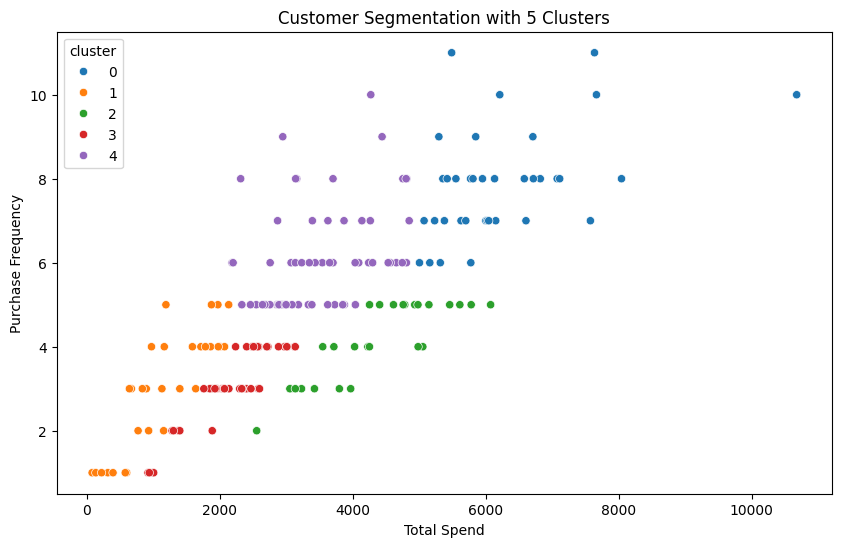

In [22]:
# Visualize clusters using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=final_data, x='total_spend', y='purchase_frequency', hue='cluster', palette='tab10')
plt.title(f'Customer Segmentation with {optimal_clusters} Clusters')
plt.xlabel('Total Spend')
plt.ylabel('Purchase Frequency')
plt.show()
